# Setup

In [1]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
if IN_COLAB:
    !pip install -q scikit-learn
    !pip install -q einops jaxtyping
    !pip install -q transformers tokenizers
    !pip install -q transformer_lens circuitsvis

In [3]:
from dataclasses import dataclass
import random
import gc
from pathlib import Path
import functools

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

import torch as t
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import einops
from tqdm.notebook import tqdm #progress bars
from typing import Tuple, List, Optional, Dict
from jaxtyping import Float, Int, Bool
from torch import Tensor

from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast

import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output
import circuitsvis as cv

import h5py
import palettable

device = t.device("cuda" if t.cuda.is_available() else "cpu")
if IN_COLAB:
    rootdir=Path('/content/drive/MyDrive/AI/plusminus/')
    traindir = rootdir/'trained_models/'
else:
    rootdir=Path('./')
    traindir=rootdir/'training_data/'
figdir = rootdir/'figures/'
print('using device: ', device)
print('rootdir is: ', rootdir)

using device:  cpu
rootdir is:  .


# Tokenizer

In [4]:
tokenizer = PreTrainedTokenizerFast(tokenizer_file=str(traindir/'tokenizer_2digit.json'), add_bos_token=True, name_or_path='2digit')
vocab = tokenizer.get_vocab()

# Model

In [5]:
@dataclass
class Config():
  d_vocab: int = len(tokenizer.get_vocab().keys())
  d_model: int = len(tokenizer.get_vocab().keys())
  d_mlp: int = 72
  n_heads: int = 8
  d_head: int = 18
  n_ctx: int = 6 #(N)(-)(N)(=)(+/-)(N)
  n_layers: int = 1

def build_hooked_transformer(cfg: Config, attn_only=False, one_hot_encode=True, norm_type='LN', **kwargs):

    hkconfig = HookedTransformerConfig(
        n_layers = cfg.n_layers,
        d_model = cfg.d_model,
        n_ctx = cfg.n_ctx,
        d_head = cfg.d_head,
        n_heads = cfg.n_heads,
        act_fn = 'relu',
        attn_only=attn_only,
        normalization_type=norm_type,
        **kwargs
    )
    model =  HookedTransformer(cfg = hkconfig, tokenizer=tokenizer)

    if attn_only:
        #Remove biases from attention heads for direct comparison with math framework paper.
        for layer in model.blocks:
            layer.attn.b_K.requires_grad = False
            layer.attn.b_O.requires_grad = False
            layer.attn.b_Q.requires_grad = False
            layer.attn.b_V.requires_grad = False

    if one_hot_encode:
        if cfg.d_model != len(tokenizer.get_vocab().keys()):
            raise ValueError("d_model != d_vocab, but that is required for one-hot encoding.")
        model.embed.W_E.requires_grad = False
        model.embed.W_E[:] = t.eye(cfg.d_model, cfg.d_model)
        model.unembed.W_U.requires_grad = False
        model.unembed.b_U.requires_grad = False
        model.unembed.W_U[:] = t.eye(cfg.d_model, cfg.d_model)
    return model

In [6]:
# Model Config
d_vocab = len(tokenizer.get_vocab().keys())
d_model = 128
n_head = 4
d_head = d_model // n_head
d_mlp  = 4 * d_model
n_layers = 1
attn_only = False
one_hot_encode = False
cfg = Config(n_layers=n_layers, d_model=d_model, n_heads=n_head, d_mlp=d_mlp, d_head=d_head)

# Load Model
tfm = build_hooked_transformer(cfg, attn_only=attn_only, one_hot_encode=one_hot_encode, norm_type=None)
tfm.to(device)
tokenizer = tfm.tokenizer
filename = traindir/'mlp_2digit_subtraction_nlayer1_nheads4_dmodel128_dhead32_seed12466689936998274052.pt'
tfm.load_state_dict(t.load(filename, map_location=device))

Moving model to device:  cpu


<All keys matched successfully>

In [7]:
# It's good to define helper variables
W_O = tfm.W_O[0]
W_K = tfm.W_K[0]
W_Q = tfm.W_Q[0]
W_V = tfm.W_V[0]
W_in = tfm.W_in[0]
W_out = tfm.W_out[0]
W_pos = tfm.W_pos
W_E = tfm.W_E
W_U = tfm.W_U

print('W_O  ', tuple(W_O.shape))
print('W_K  ', tuple(W_K.shape))
print('W_Q  ', tuple(W_Q.shape))
print('W_V  ', tuple(W_V.shape))
print('W_in ', tuple(W_in.shape))
print('W_out', tuple(W_out.shape))
print('W_pos', tuple(W_pos.shape))
print('W_E  ', tuple(W_E.shape))
print('W_U  ', tuple(W_U.shape))

W_O   (4, 32, 128)
W_K   (4, 128, 32)
W_Q   (4, 128, 32)
W_V   (4, 128, 32)
W_in  (128, 512)
W_out (512, 128)
W_pos (6, 128)
W_E   (103, 128)
W_U   (128, 103)


In [8]:
W_E_inv = t.Tensor(np.linalg.pinv(W_E.detach().numpy()))
print(W_E_inv@W_E)

tensor([[ 0.9560,  0.0467,  0.0084,  ..., -0.0189, -0.0045, -0.0137],
        [ 0.0467,  0.6950,  0.0693,  ..., -0.0012,  0.0206,  0.0223],
        [ 0.0084,  0.0693,  0.9281,  ...,  0.0232,  0.0050,  0.0049],
        ...,
        [-0.0189, -0.0012,  0.0232,  ...,  0.9425,  0.0053, -0.0093],
        [-0.0045,  0.0206,  0.0050,  ...,  0.0053,  0.9863, -0.0031],
        [-0.0137,  0.0223,  0.0049,  ..., -0.0093, -0.0031,  0.9768]],
       grad_fn=<MmBackward0>)


# Data

In [9]:
class DataHolder:

    def __init__(self, train_frac=0.3, batch_size=128):

        data = self.get_dataset()
        self.strs = self.build_strings(data)
        self.tok = self.encode(self.strs)

    def get_dataset(self):
        data = t.Tensor([(i,j) for i in range(100) for j in range(100)])
        results = data[:,:1] - data[:,-1:]
        return t.cat((data, results), dim=1).to(t.int64)

    def build_strings(self, nums: Tensor):
        iterable = zip(nums[:,0], nums[:,1], nums[:,2])
        data = [f'{n1}-{n2}={res:+d}' for n1,n2,res in iterable]
        return data

    def encode(self, str_data):
        return t.Tensor(tokenizer.batch_encode_plus(str_data).input_ids).to(t.int64)

data = DataHolder()
print(data.strs[:10])
print(data.strs[::333], data.tok[::333])

['0-0=+0', '0-1=-1', '0-2=-2', '0-3=-3', '0-4=-4', '0-5=-5', '0-6=-6', '0-7=-7', '0-8=-8', '0-9=-9']
['0-0=+0', '3-33=-30', '6-66=-60', '9-99=-90', '13-32=-19', '16-65=-49', '19-98=-79', '23-31=-8', '26-64=-38', '29-97=-68', '33-30=+3', '36-63=-27', '39-96=-57', '43-29=+14', '46-62=-16', '49-95=-46', '53-28=+25', '56-61=-5', '59-94=-35', '63-27=+36', '66-60=+6', '69-93=-24', '73-26=+47', '76-59=+17', '79-92=-13', '83-25=+58', '86-58=+28', '89-91=-2', '93-24=+69', '96-57=+39', '99-90=+9'] tensor([[  0, 101,   0, 102, 100,   0],
        [  3, 101,  33, 102, 101,  30],
        [  6, 101,  66, 102, 101,  60],
        [  9, 101,  99, 102, 101,  90],
        [ 13, 101,  32, 102, 101,  19],
        [ 16, 101,  65, 102, 101,  49],
        [ 19, 101,  98, 102, 101,  79],
        [ 23, 101,  31, 102, 101,   8],
        [ 26, 101,  64, 102, 101,  38],
        [ 29, 101,  97, 102, 101,  68],
        [ 33, 101,  30, 102, 100,   3],
        [ 36, 101,  63, 102, 101,  27],
        [ 39, 101,  96, 102

# Baseline model performance

In [10]:
def get_accuracy(
    logits: Float[Tensor, "batch posn d_vocab"],
    tokens: Int[Tensor, "batch posn"],
    meandim: int = None
) -> Float[Tensor, "batch posn-1"]:

    logit_preds = logits[:, 3:-1, :].argmax(dim=-1) #5-digit
    acc = (logit_preds == tokens[:, 4:]).to(t.float)
    return acc.mean(dim=meandim)

def get_loss(
    logits: Float[Tensor, "batch posn d_vocab"],
    tokens: Int[Tensor, "batch posn"],
    meandim: int = None
) -> Float[Tensor, "batch posn-1"]:

    log_probs = logits.log_softmax(dim=-1)
    # Get logprobs the first seq_len-1 predictions (so we can compare them with the actual next tokens)
    log_probs_for_tokens = log_probs[:, 3:-1].gather(dim=-1, index=tokens[:, 4:].unsqueeze(-1)).squeeze(-1) #5-digit
    return -log_probs_for_tokens.mean(dim=meandim)


In [11]:
original_logits, cache = tfm.run_with_cache(data.tok)
# Final 2 positions: (+/-) and number. Also remove the logits for `=`
original_loss = get_loss(original_logits, data.tok, meandim=0) #loss by digit
original_acc  = get_accuracy(original_logits, data.tok, meandim=0)
original_logits = original_logits[:, -2:, :-1]
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")

Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%


In [12]:
def approx_posembed_hook(
    embedding: Float[Tensor, "batch seq d_model"],
    hook: HookPoint,
) -> Float[Tensor, "batch seq d_model"]:
    embedding[:,:,:] = (einops.einsum(W_E_inv, W_E, W_pos, 'model vocab, vocab imodel, seq imodel -> seq model'))[None,:]


ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("pos_embed"), approx_posembed_hook)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Approximating positional embed]')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")


Approximating positional embed]
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06848554 0.01810083], Ablated acc: [98.549995 99.94    ]%


# Training dynamics

In [13]:
with h5py.File(traindir/'dynamics_mlp_2digit_subtraction_nlayer1_nheads4_dmodel128_dhead32_seed12466689936998274052.h5', 'r') as f:
    model_seed = f['model_seed'][()]
    data_seed = f['data_seed'][()]
    iters = f['iters'][()]
    train_losses = f['train_losses'][()]
    valid_losses = f['valid_losses'][()]
    train_accuracies = f['train_accuracies'][()]
    valid_accuracies = f['valid_accuracies'][()]

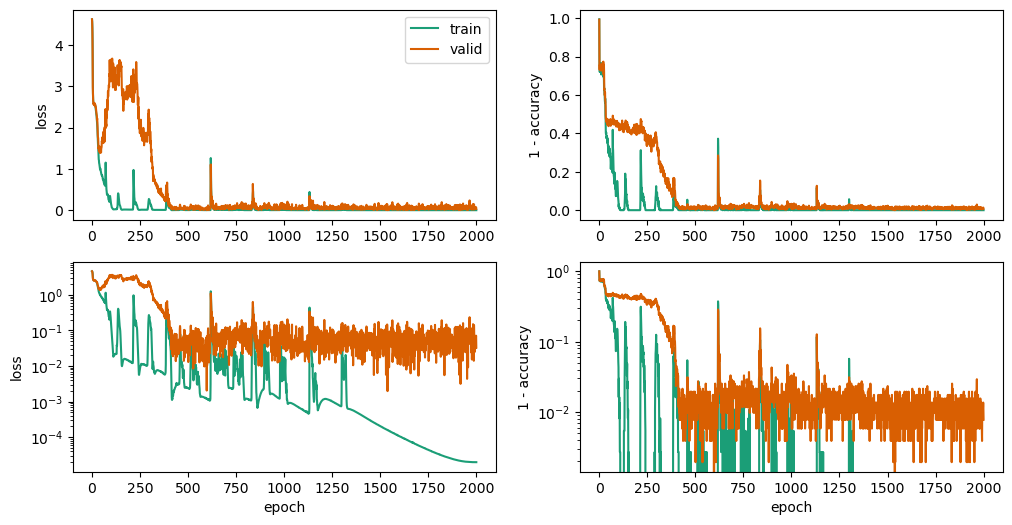

In [14]:
fig, axs = plt.subplots(2,2, figsize=(12, 6))
for i in range(2):
    for j in range(2):
        axs[i][j].set_prop_cycle('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)

axs[0][0].plot(iters, train_losses, label='train')
axs[0][0].plot(iters, valid_losses, label='valid')
axs[1][0].semilogy(iters, train_losses)
axs[1][0].semilogy(iters, valid_losses)
axs[0][0].set_ylabel('loss')
axs[1][0].set_ylabel('loss')
axs[0][0].legend()

axs[0][1].plot(iters, 1-train_accuracies)
axs[0][1].plot(iters, 1-valid_accuracies)
axs[1][1].semilogy(iters, 1-train_accuracies)
axs[1][1].semilogy(iters, 1-valid_accuracies)
axs[0][1].set_ylabel('1 - accuracy')
axs[1][1].set_ylabel('1 - accuracy')

axs[1][0].set_xlabel('epoch')
axs[1][1].set_xlabel('epoch')

fig.savefig(figdir/'training_dynamics.png', dpi=300, bbox_inches='tight')

# Matrix Periodicity

In [ ]:

fig, axs = plt.subplots(1,2, figsize=(14, 7))
axs[0].imshow(W_E.detach().numpy(), cmap='RdBu_r', vmax=W_E.abs().max().item()/2, vmin=-W_E.abs().max().item()/2, rasterized=True)
axs[0].axhline(99.5, c='k', lw=0.5)
axs[0].set_ylabel('d_vocab')
axs[0].set_xlabel('d_model')
axs[0].set_yticks(range(d_vocab));
axs[0].set_yticklabels(vocab, fontsize=3.5);

axs[1].imshow(tfm.W_U.detach().numpy(), cmap='RdBu_r', vmax=W_U.abs().max().item(), vmin=-W_U.abs().max().item(), rasterized=True)
axs[1].axvline(99.5, c='k', lw=0.5)
axs[1].set_xlabel('d_vocab')
axs[1].set_ylabel('d_model')
axs[1].set_xticks(range(d_vocab));
axs[1].set_xticklabels(vocab, rotation='vertical', fontsize=3.5);


bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
axs[0].text(0.98, 0.98, f'Embed ($\pm${W_E.abs().max().item()/2:.3f})', ha='right', va='top', bbox=bbox_props, transform=axs[0].transAxes)
axs[1].text(0.98, 0.98, f'Unembed ($\pm${W_U.abs().max().item():.3f}', ha='right', va='top', bbox=bbox_props, transform=axs[1].transAxes)
fig.savefig(figdir/'embedding_matrices.png', dpi=300, bbox_inches='tight')

<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_27558/3825337877.py:18: SyntaxWarning: invalid escape sequence '\p'
  axs[0].text(0.98, 0.98, f'Embed ($\pm${W_E.abs().max().item()/2:.3f})', ha='right', va='top', bbox=bbox_props, transform=axs[0].transAxes)
/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_27558/3825337877.py:19: SyntaxWarning: invalid escape sequence '\p'
  axs[1].text(0.98, 0.98, f'Unembed ($\pm${W_U.abs().max().item():.3f}', ha='right', va='top', bbox=bbox_props, transform=axs[1].transAxes)


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))
ax.set_prop_cycle('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)

freqs = np.fft.fftfreq(100)
fft = np.fft.fft(tfm.W_E.detach().cpu().numpy()[:100,:], axis=0)
power = np.conj(fft)*fft
plt.semilogy(freqs[freqs >=0], np.mean(power, axis=1)[freqs >=0], label='embed')

fft = np.fft.fft(tfm.W_U.detach().cpu().numpy()[:,:100], axis=1)
power = np.conj(fft)*fft
plt.semilogy(freqs[freqs >=0], np.mean(power, axis=0)[freqs >=0], label='unembed')
plt.xlabel('frequency')
plt.ylabel('power')
plt.xlim(-0.05, 0.55)

plt.axvline(freqs[freqs >= 0][1], c='k', lw=0.5)
plt.axvline(freqs[freqs >= 0][-2], c='k', lw=0.5)
plt.axvline(freqs[freqs >= 0][-11], c='k', lw=0.5)
plt.axvline(freqs[freqs >= 0][-17], c='k', lw=0.5)

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
ax.text(freqs[freqs >= 0][1],   2e-2, f'{freqs[freqs >= 0][1]:.2f}', ha='center', bbox=bbox_props)
ax.text(freqs[freqs >= 0][-2],  2e-2, f'{freqs[freqs >= 0][-2]:.2f}', ha='center', bbox=bbox_props)
ax.text(freqs[freqs >= 0][-11], 2e-2, f'{freqs[freqs >= 0][-11]:.2f}', ha='center', bbox=bbox_props)
ax.text(freqs[freqs >= 0][-17], 2e-2, f'{freqs[freqs >= 0][-17]:.2f}', ha='center', bbox=bbox_props)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(figdir/'embed_unembed_power.png', dpi=300, bbox_inches='tight')

# Residual stream spectra

## After Embedding

In [ ]:
print(cache)
resid_pre = cache['resid_pre', 0]
resid_pre_sq = einops.rearrange(resid_pre, "(x y) seq d_model  -> x y seq d_model", x=100)

In [ ]:
def freq2d_ablation_hook(
    residual: Float[Tensor, "batch seq d_model"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    
    residual_sq = einops.rearrange(residual[:,:], "(x y) seq d_mlp -> x y seq d_mlp", x=100)
    ft = np.fft.fft2(residual_sq.detach().numpy(), axes=[0,1])
    new_ft = np.zeros_like(ft)
    new_ft[0,:,:] = ft[0,:,:]
    new_ft[:,0,:] = ft[:,0,:]
    residual_sq = np.fft.ifft2(new_ft, axes=[0,1]).real
    residual_sq = t.Tensor(residual_sq)
    residual[:] = einops.rearrange(residual_sq, "x y seq d_mlp -> (x y) seq d_mlp")


ablate_freqs = functools.partial(freq2d_ablation_hook)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.hook_resid_pre"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind 2d frequencies')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

## After Attention

In [ ]:
print(cache)
resid_mid = cache['resid_mid', 0]
resid_mid_sq = einops.rearrange(resid_mid, "(x y) seq d_model  -> x y seq d_model", x=100)

In [ ]:
def freq2d_ablation_hook(
    residual: Float[Tensor, "batch seq d_model"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    
    residual_sq = einops.rearrange(residual[:,:], "(x y) seq d_mlp -> x y seq d_mlp", x=100)
    ft = np.fft.fft2(residual_sq.detach().numpy(), axes=[0,1])
    new_ft = np.zeros_like(ft)
    new_ft[0,:,:] = ft[0,:,:]
    new_ft[:,0,:] = ft[:,0,:]
    residual_sq = np.fft.ifft2(new_ft, axes=[0,1]).real
    residual_sq = t.Tensor(residual_sq)
    residual[:] = einops.rearrange(residual_sq, "x y seq d_mlp -> (x y) seq d_mlp")


ablate_freqs = functools.partial(freq2d_ablation_hook)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.hook_resid_mid"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind 2d frequencies')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

## After MLP

In [ ]:
print(cache)
resid_post = cache['resid_post', 0]
resid_post_sq = einops.rearrange(resid_post, "(x y) seq d_model  -> x y seq d_model", x=100)

In [ ]:
def freq2d_ablation_hook(
    residual: Float[Tensor, "batch seq d_model"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    
    residual_sq = einops.rearrange(residual[:,:], "(x y) seq d_mlp -> x y seq d_mlp", x=100)
    ft = np.fft.fft2(residual_sq.detach().numpy(), axes=[0,1])
    new_ft = np.zeros_like(ft)
    indices_to_keep = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    for indx in indices_to_keep:
        new_ft[indx,:,:] = ft[indx,:,:]
        new_ft[:,indx,:] = ft[:,indx,:]
        if indx != 0:
            new_ft[-indx,:,:] = ft[-indx,:,:]
            new_ft[:,-indx,:] = ft[:,-indx,:]
    residual_sq = np.fft.ifft2(new_ft, axes=[0,1]).real
    residual_sq = t.Tensor(residual_sq)
    residual[:] = einops.rearrange(residual_sq, "x y seq d_mlp -> (x y) seq d_mlp")


ablate_freqs = functools.partial(freq2d_ablation_hook)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.hook_resid_post"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind 2d frequencies')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

## Spectra Plots

In [ ]:
# Make masks
posmask = data.tok[:,-2] == 100
negmask = data.tok[:,-2] == 101

posmask_sq = einops.rearrange(posmask.numpy(), "(x y) -> x y ", x=100)[:,:,None,None]
negmask_sq = einops.rearrange(negmask.numpy(), "(x y) -> x y ", x=100)[:,:,None,None]
print(posmask_sq.shape, posmask.sum(), negmask.sum())

In [ ]:
mask = posmask_sq

ft_resid = np.fft.fft2(mask*resid_pre_sq.detach().numpy(), axes=[0,1])
power = (np.conj(ft_resid)*ft_resid).sum(axis=-1).real
power[power == 0] = 1e-16
resid_pre_power = power
resid_pre_ft = ft_resid

ft_resid = np.fft.fft2(mask*resid_mid_sq.detach().numpy(), axes=[0,1])
power = (np.conj(ft_resid)*ft_resid).sum(axis=-1).real
power[power == 0] = 1e-16
resid_mid_power = power
resid_mid_ft = ft_resid

ft_resid = np.fft.fft2(mask*resid_post_sq.detach().numpy(), axes=[0,1])
power = (np.conj(ft_resid)*ft_resid).sum(axis=-1).real
power[power == 0] = 1e-16
resid_post_power = power
resid_post_ft = ft_resid



fig, axs = plt.subplots(2,2, figsize=(16,16))
plot = axs[0][0].imshow(np.log10(resid_pre_power)[:,:,0], cmap='plasma', vmin=0, vmax=6)
cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
cbar.set_label(r'$\log_{10}(\rm{Residual}\,\rm{Stream}\,\rm{Power})$ (summed over model dimensions)')
axs[0][0].set_ylim(-0.5, 99.5)
axs[0][0].set_yticks(range(100));
axs[0][0].set_yticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7);
axs[0][0].set_xticks(range(100));
axs[0][0].set_xticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7, rotation='vertical');
axs[0][0].set_ylabel('frequency in batch dimension 1 (a varies)')
axs[0][0].set_xlabel('frequency in batch dimension 2 (b varies)')
axs[0][0].text(0.98, 0.98, f'Residual stream after embedding (sequence position=0)', ha='right', va='top', bbox=bbox_props, transform=axs[0][0].transAxes)


plot = axs[0][1].imshow(np.log10(resid_pre_power)[:,:,2], cmap='plasma', vmin=0, vmax=6)
cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
cbar.set_label(r'$\log_{10}(\rm{Residual}\,\rm{Stream}\,\rm{Power})$ (summed over model dimensions)')
axs[0][1].set_ylim(-0.5, 99.5)
axs[0][1].set_yticks(range(100));
axs[0][1].set_yticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7);
axs[0][1].set_xticks(range(100));
axs[0][1].set_xticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7, rotation='vertical');
axs[0][1].set_ylabel('frequency in batch dimension 1 (a varies)')
axs[0][1].set_xlabel('frequency in batch dimension 2 (b varies)')
axs[0][1].text(0.98, 0.98, f'Residual stream after embedding (sequence position=2)', ha='right', va='top', bbox=bbox_props, transform=axs[0][1].transAxes)


plot = axs[1][0].imshow(np.log10(resid_mid_power)[:,:,3], cmap='plasma', vmin=0, vmax=6)
cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
cbar.set_label(r'$\log_{10}(\rm{Residual}\,\rm{Stream}\,\rm{Power})$ (summed over model dimensions)')
axs[1][0].set_ylim(-0.5, 99.5)
axs[1][0].set_yticks(range(100));
axs[1][0].set_yticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7);
axs[1][0].set_xticks(range(100));
axs[1][0].set_xticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7, rotation='vertical');
axs[1][0].set_ylabel('frequency in batch dimension 1 (a varies)')
axs[1][0].set_xlabel('frequency in batch dimension 2 (b varies)')
axs[1][0].text(0.98, 0.98, f'Residual stream after attention (sequence position=3)', ha='right', va='top', bbox=bbox_props, transform=axs[1][0].transAxes)


plot = axs[1][1].imshow(np.log10(resid_post_power)[:,:,3], cmap='plasma', vmin=4, vmax=10)
cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
cbar.set_label(r'$\log_{10}(\rm{Residual}\,\rm{Stream}\,\rm{Power})$ (summed over model dimensions)')
axs[1][1].set_ylim(-0.5, 99.5)
axs[1][1].set_yticks(range(100));
axs[1][1].set_yticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7);
axs[1][1].set_xticks(range(100));
axs[1][1].set_xticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7, rotation='vertical');
axs[1][1].set_ylabel('frequency in batch dimension 1 (a varies)')
axs[1][1].set_xlabel('frequency in batch dimension 2 (b varies)')
axs[1][1].text(0.98, 0.98, f'Residual stream after MLP (sequence position=3)', ha='right', va='top', bbox=bbox_props, transform=axs[1][1].transAxes)

fig.savefig(figdir/'residual_stream_power_spectra_posmask_tokpos03.png', dpi=300)

In [ ]:
mask = negmask_sq

ft_resid = np.fft.fft2(mask*resid_pre_sq.detach().numpy(), axes=[0,1])
power = (np.conj(ft_resid)*ft_resid).sum(axis=-1).real
power[power == 0] = 1e-16
resid_pre_power = power
resid_pre_ft = ft_resid

ft_resid = np.fft.fft2(mask*resid_mid_sq.detach().numpy(), axes=[0,1])
power = (np.conj(ft_resid)*ft_resid).sum(axis=-1).real
power[power == 0] = 1e-16
resid_mid_power = power
resid_mid_ft = ft_resid

ft_resid = np.fft.fft2(mask*resid_post_sq.detach().numpy(), axes=[0,1])
power = (np.conj(ft_resid)*ft_resid).sum(axis=-1).real
power[power == 0] = 1e-16
resid_post_power = power
resid_post_ft = ft_resid



fig, axs = plt.subplots(2,2, figsize=(16,16))
plot = axs[0][0].imshow(np.log10(resid_pre_power)[:,:,0], cmap='plasma', vmin=0, vmax=6)
cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
cbar.set_label(r'$\log_{10}(\rm{Residual}\,\rm{Stream}\,\rm{Power})$ (summed over model dimensions)')
axs[0][0].set_ylim(-0.5, 99.5)
axs[0][0].set_yticks(range(100));
axs[0][0].set_yticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7);
axs[0][0].set_xticks(range(100));
axs[0][0].set_xticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7, rotation='vertical');
axs[0][0].set_ylabel('frequency in batch dimension 1 (a varies)')
axs[0][0].set_xlabel('frequency in batch dimension 2 (b varies)')
axs[0][0].text(0.98, 0.98, f'Residual stream after embedding (sequence position=0)', ha='right', va='top', bbox=bbox_props, transform=axs[0][0].transAxes)


plot = axs[0][1].imshow(np.log10(resid_pre_power)[:,:,2], cmap='plasma', vmin=0, vmax=6)
cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
cbar.set_label(r'$\log_{10}(\rm{Residual}\,\rm{Stream}\,\rm{Power})$ (summed over model dimensions)')
axs[0][1].set_ylim(-0.5, 99.5)
axs[0][1].set_yticks(range(100));
axs[0][1].set_yticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7);
axs[0][1].set_xticks(range(100));
axs[0][1].set_xticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7, rotation='vertical');
axs[0][1].set_ylabel('frequency in batch dimension 1 (a varies)')
axs[0][1].set_xlabel('frequency in batch dimension 2 (b varies)')
axs[0][1].text(0.98, 0.98, f'Residual stream after embedding (sequence position=2)', ha='right', va='top', bbox=bbox_props, transform=axs[0][1].transAxes)


plot = axs[1][0].imshow(np.log10(resid_mid_power)[:,:,3], cmap='plasma', vmin=0, vmax=6)
cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
cbar.set_label(r'$\log_{10}(\rm{Residual}\,\rm{Stream}\,\rm{Power})$ (summed over model dimensions)')
axs[1][0].set_ylim(-0.5, 99.5)
axs[1][0].set_yticks(range(100));
axs[1][0].set_yticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7);
axs[1][0].set_xticks(range(100));
axs[1][0].set_xticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7, rotation='vertical');
axs[1][0].set_ylabel('frequency in batch dimension 1 (a varies)')
axs[1][0].set_xlabel('frequency in batch dimension 2 (b varies)')
axs[1][0].text(0.98, 0.98, f'Residual stream after attention (sequence position=3)', ha='right', va='top', bbox=bbox_props, transform=axs[1][0].transAxes)


plot = axs[1][1].imshow(np.log10(resid_post_power)[:,:,3], cmap='plasma', vmin=4, vmax=10)
cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
cbar.set_label(r'$\log_{10}(\rm{Residual}\,\rm{Stream}\,\rm{Power})$ (summed over model dimensions)')
axs[1][1].set_ylim(-0.5, 99.5)
axs[1][1].set_yticks(range(100));
axs[1][1].set_yticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7);
axs[1][1].set_xticks(range(100));
axs[1][1].set_xticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7, rotation='vertical');
axs[1][1].set_ylabel('frequency in batch dimension 1 (a varies)')
axs[1][1].set_xlabel('frequency in batch dimension 2 (b varies)')
axs[1][1].text(0.98, 0.98, f'Residual stream after MLP (sequence position=3)', ha='right', va='top', bbox=bbox_props, transform=axs[1][1].transAxes)

fig.savefig(figdir/'residual_stream_power_spectra_negmask_tokpos03.png', dpi=300)

In [ ]:
mask = 1

ft_resid = np.fft.fft2(mask*resid_pre_sq.detach().numpy(), axes=[0,1])
power = (np.conj(ft_resid)*ft_resid).sum(axis=-1).real
power[power == 0] = 1e-16
resid_pre_power = power
resid_pre_ft = ft_resid

ft_resid = np.fft.fft2(mask*resid_mid_sq.detach().numpy(), axes=[0,1])
power = (np.conj(ft_resid)*ft_resid).sum(axis=-1).real
power[power == 0] = 1e-16
resid_mid_power = power
resid_mid_ft = ft_resid

ft_resid = np.fft.fft2(mask*resid_post_sq.detach().numpy(), axes=[0,1])
power = (np.conj(ft_resid)*ft_resid).sum(axis=-1).real
power[power == 0] = 1e-16
resid_post_power = power
resid_post_ft = ft_resid



fig, axs = plt.subplots(2,2, figsize=(16,16))
plot = axs[0][0].imshow(np.log10(resid_pre_power)[:,:,0], cmap='plasma', vmin=0, vmax=6)
cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
cbar.set_label(r'$\log_{10}(\rm{Residual}\,\rm{Stream}\,\rm{Power})$ (summed over model dimensions)')
axs[0][0].set_ylim(-0.5, 99.5)
axs[0][0].set_yticks(range(100));
axs[0][0].set_yticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7);
axs[0][0].set_xticks(range(100));
axs[0][0].set_xticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7, rotation='vertical');
axs[0][0].set_ylabel('frequency in batch dimension 1 (a varies)')
axs[0][0].set_xlabel('frequency in batch dimension 2 (b varies)')
axs[0][0].text(0.98, 0.98, f'Residual stream after embedding (sequence position=0)', ha='right', va='top', bbox=bbox_props, transform=axs[0][0].transAxes)


plot = axs[0][1].imshow(np.log10(resid_pre_power)[:,:,2], cmap='plasma', vmin=0, vmax=6)
cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
cbar.set_label(r'$\log_{10}(\rm{Residual}\,\rm{Stream}\,\rm{Power})$ (summed over model dimensions)')
axs[0][1].set_ylim(-0.5, 99.5)
axs[0][1].set_yticks(range(100));
axs[0][1].set_yticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7);
axs[0][1].set_xticks(range(100));
axs[0][1].set_xticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7, rotation='vertical');
axs[0][1].set_ylabel('frequency in batch dimension 1 (a varies)')
axs[0][1].set_xlabel('frequency in batch dimension 2 (b varies)')
axs[0][1].text(0.98, 0.98, f'Residual stream after embedding (sequence position=2)', ha='right', va='top', bbox=bbox_props, transform=axs[0][1].transAxes)


plot = axs[1][0].imshow(np.log10(resid_mid_power)[:,:,3], cmap='plasma', vmin=0, vmax=6)
cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
cbar.set_label(r'$\log_{10}(\rm{Residual}\,\rm{Stream}\,\rm{Power})$ (summed over model dimensions)')
axs[1][0].set_ylim(-0.5, 99.5)
axs[1][0].set_yticks(range(100));
axs[1][0].set_yticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7);
axs[1][0].set_xticks(range(100));
axs[1][0].set_xticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7, rotation='vertical');
axs[1][0].set_ylabel('frequency in batch dimension 1 (a varies)')
axs[1][0].set_xlabel('frequency in batch dimension 2 (b varies)')
axs[1][0].text(0.98, 0.98, f'Residual stream after attention (sequence position=3)', ha='right', va='top', bbox=bbox_props, transform=axs[1][0].transAxes)


plot = axs[1][1].imshow(np.log10(resid_post_power)[:,:,3], cmap='plasma', vmin=4, vmax=10)
cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
cbar.set_label(r'$\log_{10}(\rm{Residual}\,\rm{Stream}\,\rm{Power})$ (summed over model dimensions)')
axs[1][1].set_ylim(-0.5, 99.5)
axs[1][1].set_yticks(range(100));
axs[1][1].set_yticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7);
axs[1][1].set_xticks(range(100));
axs[1][1].set_xticklabels([f'{freq:.2f}' if np.round(100*freq) % 2 == 1 else '' for freq in freqs], fontsize=7, rotation='vertical');
axs[1][1].set_ylabel('frequency in batch dimension 1 (a varies)')
axs[1][1].set_xlabel('frequency in batch dimension 2 (b varies)')
axs[1][1].text(0.98, 0.98, f'Residual stream after MLP (sequence position=3)', ha='right', va='top', bbox=bbox_props, transform=axs[1][1].transAxes)

fig.savefig(figdir/'residual_stream_power_spectra_nomask_tokpos03.png', dpi=300)

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
for ax in axs:
    ax.set_prop_cycle('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)
good = freqs >= 0

for ax, offset in zip(axs, [2e3, 6e3, 2.7e5]):
    ax.plot(freqs[good], offset*(0.01/freqs[good]))
axs[0].text(0.85, 0.05, '$f^{-1}$', fontsize=14, ha='right', va='bottom', transform=axs[0].transAxes, color= palettable.colorbrewer.qualitative.Dark2_8.mpl_colors[0])

axs[0].loglog(freqs[good], np.sqrt(resid_pre_power[:,0,0][good]), label = r'$f_{\rm a} = 0$; pos 0')
axs[0].loglog(freqs[good], np.sqrt(resid_pre_power[0,:,2][good]), label = r'$f_{\rm b} = 0$; pos 2', ls='--')
axs[1].loglog(freqs[good], np.sqrt(resid_mid_power[:,0,3][good]), label = r'$f_{\rm a} = 0$; pos 3')
axs[2].loglog(freqs[good], np.sqrt(resid_post_power[:,0,3][good]), label = r'$f_{\rm a} = 0$; pos 3')




for ax in axs:
    ax.legend()
    ax.set_xlabel('frequency')
axs[0].set_ylabel('power')
fig.savefig(figdir/'sliced_power.png', bbox_inches='tight', dpi=300)